In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Stochastic Environment

In [18]:
prices = np.linspace(0, 1, 100)
n_customers = 100

conversion_probability = lambda p: 1-p
cost = 0.5
min_price, max_price = 0, 1
reward_function = lambda price, n_sales: (price-cost)*n_sales

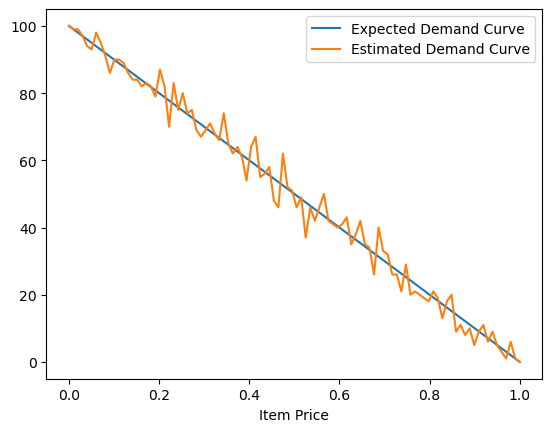

In [19]:
expected_demand_curve = n_customers*conversion_probability(prices)
estimated_demand_curve = np.random.binomial(n_customers, conversion_probability(prices))

plt.figure()
plt.plot(prices, expected_demand_curve, label='Expected Demand Curve')
plt.plot(prices, estimated_demand_curve, label='Estimated Demand Curve')
plt.xlabel('Item Price')
plt.legend()
plt.show();

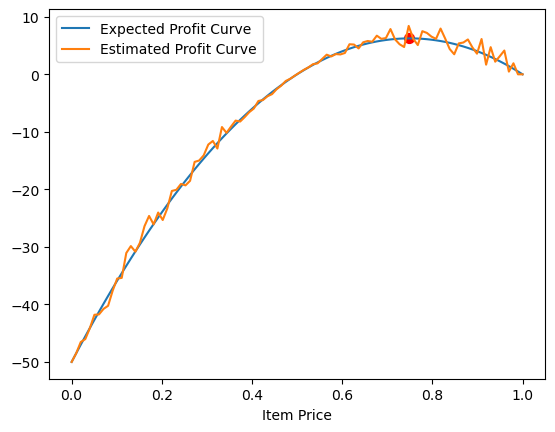

In [20]:
expected_profit_curve = n_customers*conversion_probability(prices)*(prices-cost)
estimated_profit_curve = np.random.binomial(n_customers, conversion_probability(prices))*(prices-cost)

best_price_index = np.argmax(expected_profit_curve)
best_price = prices[best_price_index]

plt.figure()
plt.plot(prices, expected_profit_curve, label='Expected Profit Curve')
plt.plot(prices, estimated_profit_curve, label='Estimated Profit Curve')
plt.scatter(best_price, expected_profit_curve[best_price_index], color='red', s=50)
plt.xlabel('Item Price')
plt.legend()
plt.show();

# Pricing in Stochastical Environment

In [21]:
class Environment:
    def __init__(self):
        pass

    def round(self, a_t):
        pass

In [22]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t)) # number of sells
        r_t = (p_t - self.cost)*d_t # reward
        return d_t, r_t

In [23]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [24]:
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=1).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(self.t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

In [25]:
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

def run_pricing(T, conversion_probability, cost, prices, n_customers, reward_function):
    agent = GPUCBAgent(T)
    np.random.seed(2)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

    # let's compute the clairvoyant
    profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
    best_price_index = np.argmax(profit_curve)
    best_price = prices[best_price_index]
    expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

    agent_rewards = np.array([])
    for t in range(T):
        p_t = agent.pull_arm()
        d_t, r_t = env.round(p_t, n_customers)
        agent.update(r_t/n_customers)
        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    prices = rescale(agent.action_hist, min_price, max_price)
    profits = agent.reward_hist
    return cumulative_regret, prices, profits, expected_clairvoyant_rewards, agent_rewards, best_price

In [26]:
def plot_gp_and_regret(prices, profits, best_price, cumulative_regret, T, expected_clairvoyant_rewards, agent_rewards):
    # Gaussian Process Regression
    gp = RBFGaussianProcess(scale=1)
    gp.fit(prices, profits)
    mu, sigma = gp.predict(np.linspace(0,1,100))

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Plot 1: GPUCB - Final estimated profit curve
    axs[0].scatter(prices, profits, label='Samples', color='C1')
    axs[0].plot(np.linspace(0, 1, 100), mu, label='Average Normalized Profit', color='C0')
    axs[0].axvline(best_price, color='red', label='Optimal Price')
    axs[0].fill_between(np.linspace(0, 1, 100), mu - sigma, mu + sigma, alpha=0.3, label='Uncertainty', color='C0')
    axs[0].set_title('GPUCB - Final estimated profit curve (normalized)')
    axs[0].set_xlabel('Price')
    axs[0].legend()

    # Plot 2: Cumulative Regret of GP-UCB
    axs[1].plot(cumulative_regret, label='Cumulative Regret')
    times = range(1, T + 1)
    axs[1].plot(times, cumulative_regret / np.array(times), label='Cumulative Regret over time')
    axs[1].set_title('Cumulative Regret of GP-UCB')
    axs[1].set_xlabel('$t$')
    axs[1].legend()

    # Print additional information
    theoretical_bound = np.sqrt(T) * len(prices)
    actual_total_regret = sum(expected_clairvoyant_rewards) - sum(agent_rewards)
    print(f'Theoretical bound: {theoretical_bound}')
    print(f'Actual Total Regret: {actual_total_regret}')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


## Try different parameters

Theoretical bound: 31622.776601683792
Actual Total Regret: 244.71079481680408


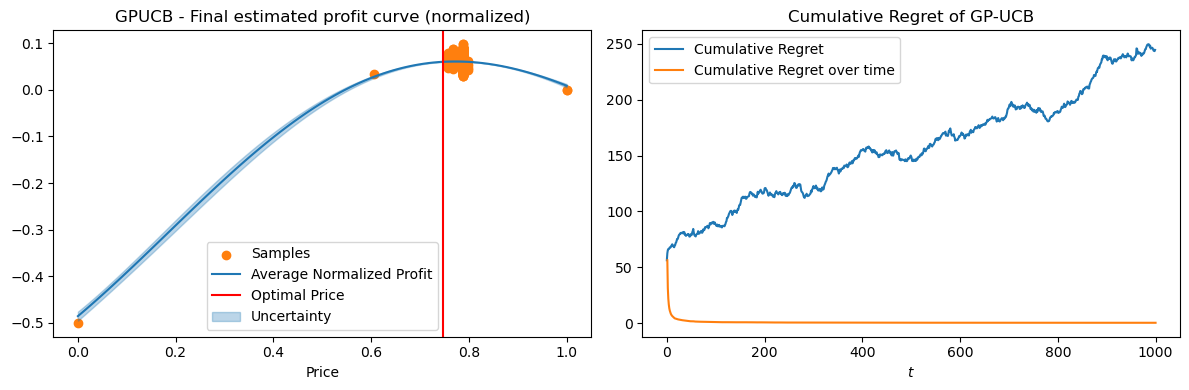

In [44]:
T = 1000
prices = np.linspace(0, 1, 100)
n_customers = 100
conversion_probability = lambda p: 1-p
cost = 0.5
min_price, max_price = 0, 1
reward_function = lambda price, n_sales: (price-cost)*n_sales
cumulative_regret, prices, profits, expected_clairvoyant_rewards, agent_rewards,best_price = run_pricing(T, conversion_probability, cost, prices, n_customers, reward_function)
plot_gp_and_regret(prices, profits, best_price, cumulative_regret, T, expected_clairvoyant_rewards, agent_rewards)

Theoretical bound: 31622.776601683792
Actual Total Regret: 101.51010101010252


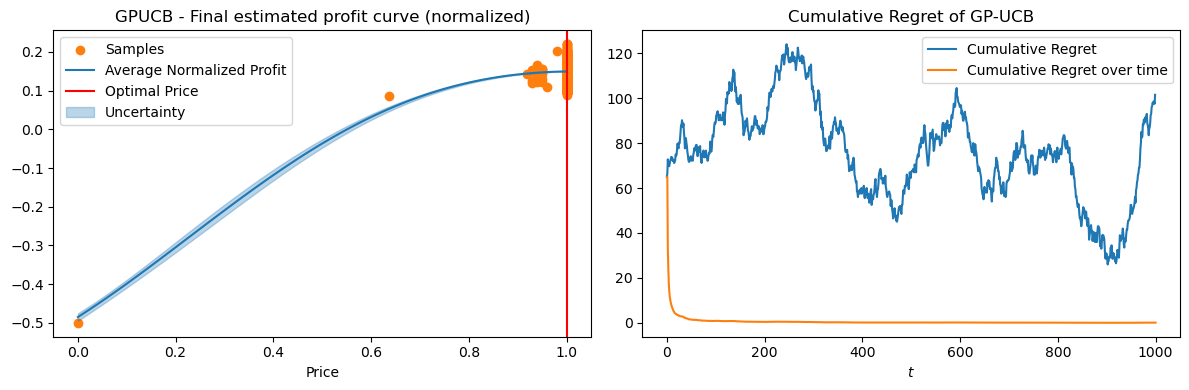

In [45]:
T = 1000
n_customers = 100
conversion_probability = lambda p: 1-0.7*p
cost = 0.5
min_price, max_price = 0, 1
reward_function = lambda price, n_sales: (price-cost)*n_sales
cumulative_regret, prices, profits, expected_clairvoyant_rewards, agent_rewards, best_price = run_pricing(T, conversion_probability, cost, prices, n_customers, reward_function)
plot_gp_and_regret(prices, profits, best_price, cumulative_regret, T, expected_clairvoyant_rewards, agent_rewards)

Theoretical bound: 31622.776601683792
Actual Total Regret: 78.77959216673662


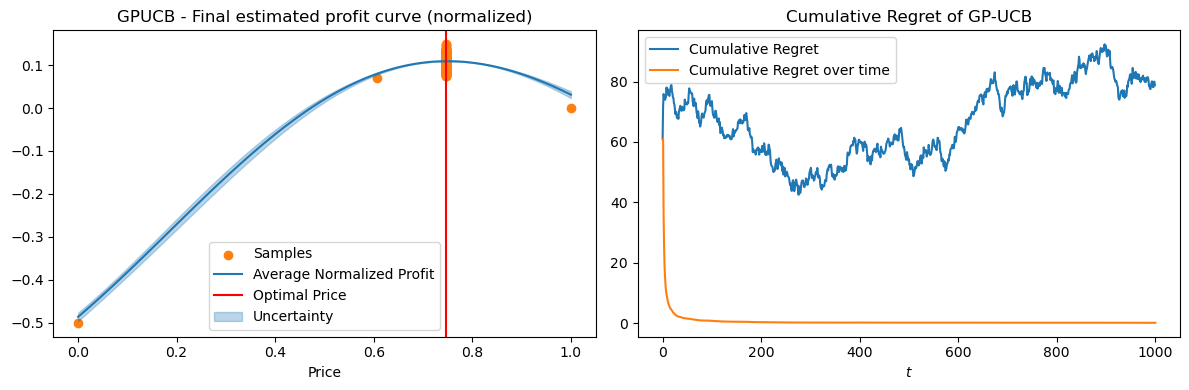

In [47]:
T = 1000
n_customers = 100
conversion_probability = lambda p: 1-p**2
cost = 0.5
min_price, max_price = 0, 1
reward_function = lambda price, n_sales: (price-cost)*n_sales
cumulative_regret, prices, profits, expected_clairvoyant_rewards, agent_rewards, best_price = run_pricing(T, conversion_probability, cost, prices, n_customers, reward_function)
plot_gp_and_regret(prices, profits, best_price, cumulative_regret, T, expected_clairvoyant_rewards, agent_rewards)

Theoretical bound: 31622.776601683792
Actual Total Regret: 112.73408835833158


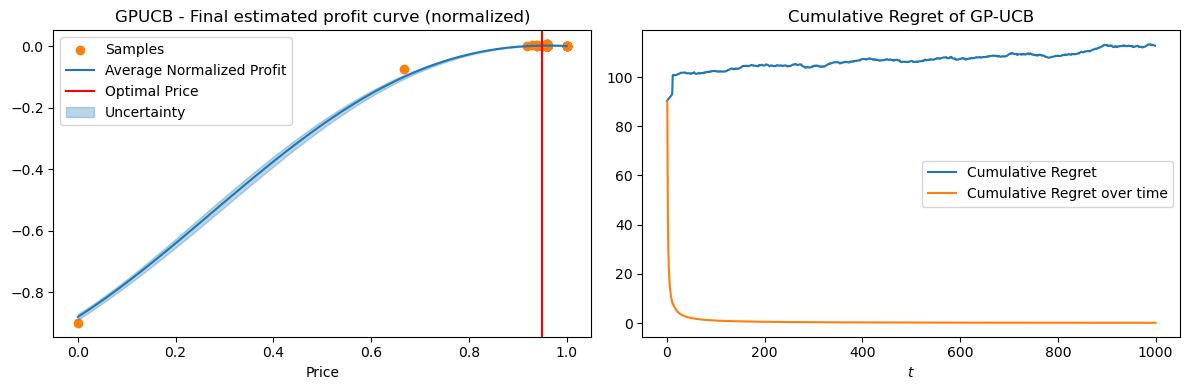

In [49]:
T = 1000
n_customers = 100
conversion_probability = lambda p: 1-p
cost = 0.9
min_price, max_price = 0, 1
reward_function = lambda price, n_sales: (price-cost)*n_sales
cumulative_regret, prices, profits, expected_clairvoyant_rewards, agent_rewards, best_price = run_pricing(T, conversion_probability, cost, prices, n_customers, reward_function)
plot_gp_and_regret(prices, profits, best_price, cumulative_regret, T, expected_clairvoyant_rewards, agent_rewards)

Theoretical bound: 31622.776601683792
Actual Total Regret: 239.60927456396348


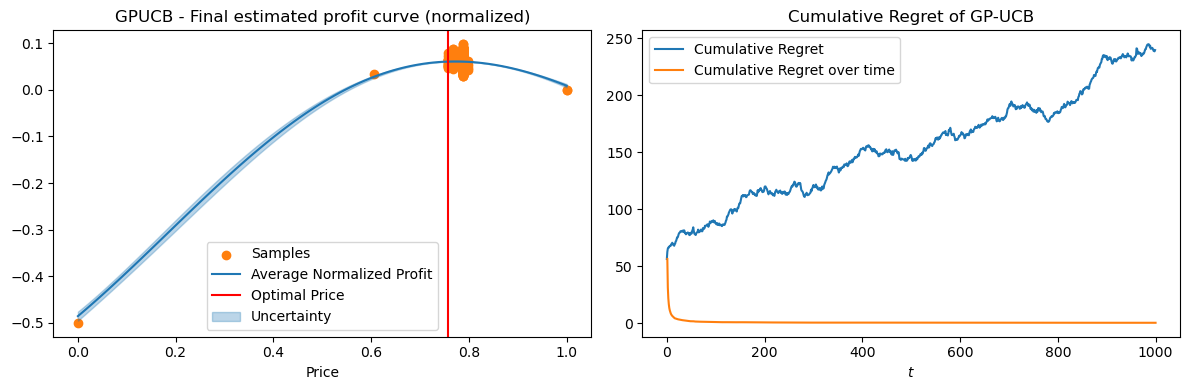

In [42]:
T = 1000
n_customers = 100
conversion_probability = lambda p: 1-p
cost = 0.5
min_price, max_price = 0, 1
reward_function = lambda price, n_sales: (price-cost)*n_sales
cumulative_regret, prices, profits, expected_clairvoyant_rewards, agent_rewards, best_price = run_pricing(T, conversion_probability, cost, prices, n_customers, reward_function)
plot_gp_and_regret(prices, profits, best_price, cumulative_regret, T, expected_clairvoyant_rewards, agent_rewards)

By trying out different parameters, we can see that we achieve sublinear regret for our setting for all chosen parameters. So our implementation works for different conversion probability and costs. We can observe that the agent samples only a few prices with a bad profit. Thus it converges to the aria around the optimal price fastly. By choosing the cost high we observe that it is easier to learn the pricing. The algorithm converges to the clairvoyant in a few steps. Moreover the cumulative regret is more stable. That might be due to the smaller available prices to pick.